# import libraries

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random

#LOAD DATA

In [26]:
import json

# Load the content of intents.json
file_path = "/content/intents.json"
with open(file_path, 'r') as file:
    intents_data = json.load(file)

intents_data


{'intents': [{'tag': 'greeting',
   'patterns': ['Hi there',
    'How are you',
    'Is anyone there?',
    'Hey',
    'Hola',
    'Hello',
    'Good day'],
   'responses': ['Hello, thanks for asking',
    'Good to see you again',
    'Hi there, how can I help?'],
   'context': ['']},
  {'tag': 'goodbye',
   'patterns': ['Bye',
    'See you later',
    'Goodbye',
    'Nice chatting to you, bye',
    'Till next time'],
   'responses': ['See you!', 'Have a nice day', 'Bye! Come back again soon.'],
   'context': ['']},
  {'tag': 'thanks',
   'patterns': ['Thanks',
    'Thank you',
    "That's helpful",
    'Awesome, thanks',
    'Thanks for helping me'],
   'responses': ['Happy to help!', 'Any time!', 'My pleasure'],
   'context': ['']},
  {'tag': 'noanswer',
   'patterns': [],
   'responses': ["Sorry, can't understand you",
    'Please give me more info',
    'Not sure I understand'],
   'context': ['']},
  {'tag': 'options',
   'patterns': ['How you could help me?',
    'What you can do

In [18]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('intents.json').read()
intents = json.loads(data_file)


for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [19]:
# lemmaztize and lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

47 documents
9 classes ['adverse_drug', 'blood_pressure', 'blood_pressure_search', 'goodbye', 'greeting', 'hospital_search', 'options', 'pharmacy_search', 'thanks']
88 unique lemmatized words ["'s", ',', 'a', 'adverse', 'all', 'anyone', 'are', 'awesome', 'be', 'behavior', 'blood', 'by', 'bye', 'can', 'causing', 'chatting', 'check', 'could', 'data', 'day', 'detail', 'do', 'dont', 'drug', 'entry', 'find', 'for', 'give', 'good', 'goodbye', 'have', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'history', 'hola', 'hospital', 'how', 'i', 'id', 'is', 'later', 'list', 'load', 'locate', 'log', 'looking', 'lookup', 'management', 'me', 'module', 'nearby', 'next', 'nice', 'of', 'offered', 'open', 'patient', 'pharmacy', 'pressure', 'provide', 'reaction', 'related', 'result', 'search', 'searching', 'see', 'show', 'suitable', 'support', 'task', 'thank', 'thanks', 'that', 'there', 'till', 'time', 'to', 'transfer', 'up', 'want', 'what', 'which', 'with', 'you']


words: This list is used to store all the words found in the patterns of the intents.

classes: This list is used to store unique tags (intents) present in the intents file.

documents: This list is used to store pairs of tokenized words and their corresponding intent tags.

In [20]:
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

# create our training data


In [21]:
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


<ipython-input-21-14f4db91aa1f>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


#MODEL

In [23]:

# Assume you have defined 'train_x' and 'train_y'

# Create model - 3 layers.
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Define a learning rate schedule with decay.
def lr_schedule(epoch):
    initial_lr = 0.01
    decay_factor = 0.1
    decay_epochs = 50
    lrate = initial_lr * decay_factor ** (epoch // decay_epochs)
    return lrate

# Compile model.
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the best model.
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='accuracy', mode='max', verbose=1)

# Fitting and saving the model with learning rate schedule and model checkpoint.
lr_scheduler = LearningRateScheduler(lr_schedule)
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1, callbacks=[lr_scheduler, model_checkpoint])

print("Best model created and saved based on accuracy.")


Epoch 1/200
 1/10 [==>...........................] - ETA: 3s - loss: 2.2714 - accuracy: 0.2000
Epoch 1: accuracy improved from -inf to 0.12766, saving model to best_model.h5
10/10 [==============================] - 0s 3ms/step - loss: 2.2025 - accuracy: 0.1277 - lr: 0.0100
Epoch 2/200
 1/10 [==>...........................] - ETA: 0s - loss: 2.2932 - accuracy: 0.2000
Epoch 2: accuracy did not improve from 0.12766
10/10 [==============================] - 0s 2ms/step - loss: 2.2267 - accuracy: 0.0851 - lr: 0.0100
Epoch 3/200
 1/10 [==>...........................] - ETA: 0s - loss: 2.0203 - accuracy: 0.2000
Epoch 3: accuracy improved from 0.12766 to 0.17021, saving model to best_model.h5
10/10 [==============================] - 0s 3ms/step - loss: 2.1112 - accuracy: 0.1702 - lr: 0.0100
Epoch 4/200
 1/10 [==>...........................] - ETA: 0s - loss: 2.0978 - accuracy: 0.2000
Epoch 4: accuracy improved from 0.17021 to 0.36170, saving model to best_model.h5
10/10 [=======================

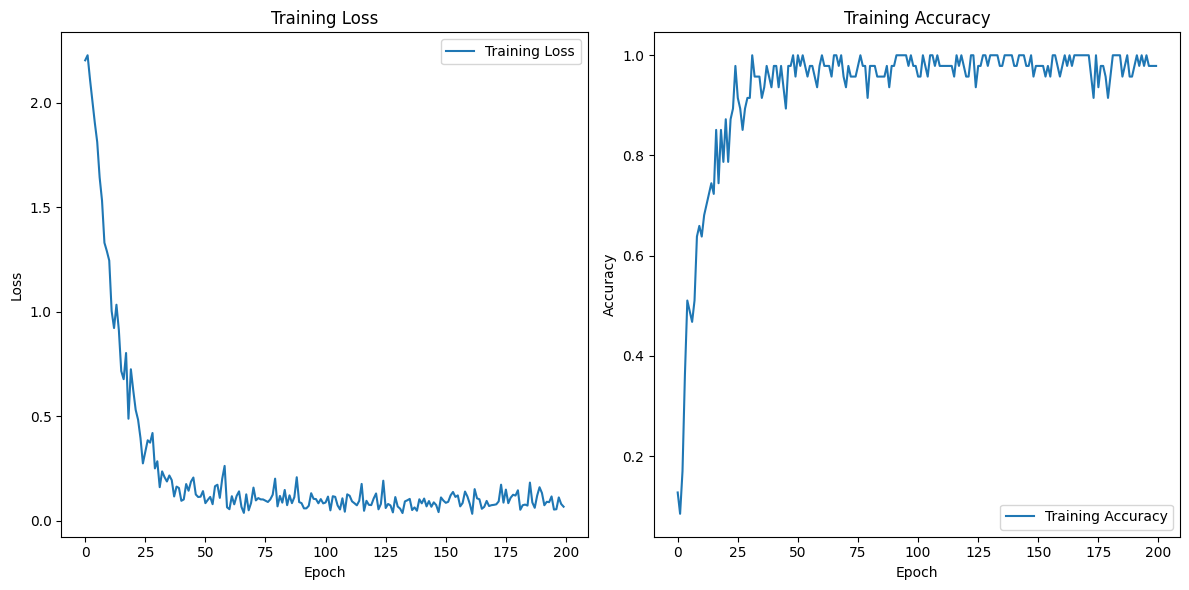

In [27]:
import matplotlib.pyplot as plt

# Assuming 'hist' contains the training history
# (the output of model.fit() method)

# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


#CHAT

In [24]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
import numpy as np

from keras.models import load_model
model = load_model('/content/best_model.h5')
import json
import random
intents = json.loads(open('/content/intents.json').read())
words = pickle.load(open('/content/words.pkl','rb'))
classes = pickle.load(open('/content/classes.pkl','rb'))


def clean_up_sentence(sentence):
    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence

def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = getResponse(ints, intents)
    return res


# Example input

In [28]:

user_input = "Hi, how are you?"

# Get the chatbot response
response = chatbot_response(user_input)

# Print the response
print(response)

1/1 [==============================] - 0s 16ms/step
Hi there, how can I help?
